In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast
import numpy as np
import statsmodels.api as sm
import HiguchiFractalDimension as hfd
import pywt

In [2]:
#defenition of data path and excel file path
path = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/'
excel = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/ptbxl_database.csv'

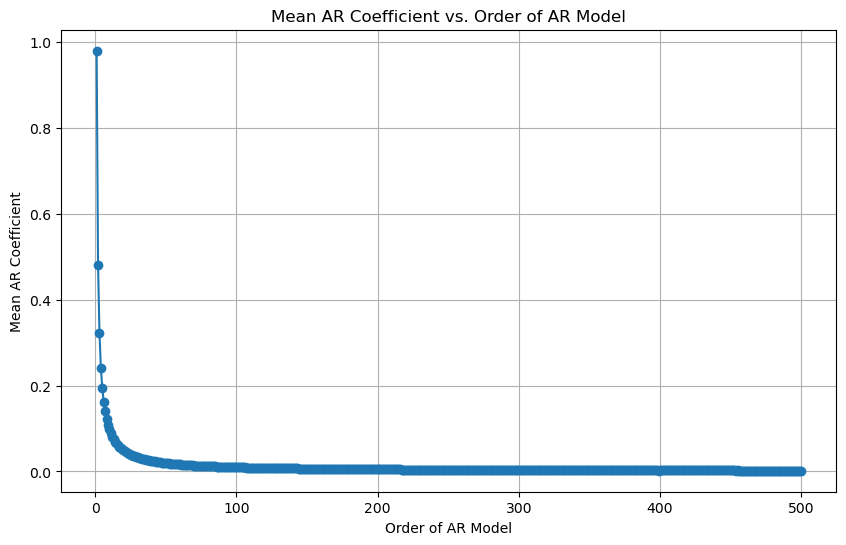

In [26]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example ECG signal (replace with your actual signal loading code)
# Assuming 'signal' contains the ECG signal data
# ecg_signal = signal.flatten()

# Generating random signal for demonstration
# ecg_signal = np.random.rand(1000)  # Replace with your actual signal data

max_order = 500
mean_coeffs = []

for order in range(1, max_order + 1):
    ar_coeffs, ar_sigma = sm.regression.yule_walker(ecg_signal, order=order)
    mean_coeffs.append(np.mean(ar_coeffs))

# Plotting mean AR coefficients versus order
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_order + 1), mean_coeffs, marker='o', linestyle='-')
plt.xlabel('Order of AR Model')
plt.ylabel('Mean AR Coefficient')
plt.title('Mean AR Coefficient vs. Order of AR Model')
plt.grid(True)
plt.show()


In [3]:
import HiguchiFractalDimension as hfd

a = hfd.hfd(ecg_signal)
print(a)

NameError: name 'ecg_signal' is not defined

In [69]:
import pywt

# Define wavelet and level of decomposition
wavelet = 'db2'
level = 6

# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

# Calculate wavelet variance
wavelet_variance = np.sum(np.square(coeffs[1])) / len(ecg_signal)
print("Wavelet Variance:", wavelet_variance)


Wavelet Variance: 0.004710194737439653


In [9]:
from scipy.stats import entropy

# Calculate Shannon's entropy
entropy_value = entropy(ecg_signal[:1500])
print("Shannon's Entropy:", entropy_value)


Shannon's Entropy: -inf


In [3]:
#custom class definition
import pandas as pd
import numpy as np
import ast
import wfdb
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.signal import butter, filtfilt
from scipy.stats import kurtosis,skew
from statsmodels.tsa.ar_model import AutoReg



class Custom_class(Dataset):
    def __init__(self, excelfile, path, num_data, transform=None, data_split='train', fold=None):
        self.dat = pd.read_csv(excelfile)
        self.col = self.dat['filename_hr']  # only 500 hz files are used for training
        self.label = self.dat['scp_codes']  # used for labeling
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.data_split = data_split
        self.fold = fold

        if self.data_split == 'train':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] != fold)]
        elif self.data_split == 'test':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]
        elif self.data_split == 'val':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        y, _ = wfdb.rdsamp(self.path + self.col[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)

        mean = np.mean(y, axis=1)[:, np.newaxis]  # Shape (12, 1)
        skewness = skew(y, axis=1)[:, np.newaxis]  # Shape (12, 1)
        kurtosiss = kurtosis(y, axis=1)[:, np.newaxis]  # Shape (12, 1)
        mean_of_means = np.mean(mean, axis=0)  # Size 12, representing mean of means across the batch
        mean_of_skewness = np.mean(skewness, axis=0)  # Size 12, representing mean of skewness across the batch
        mean_of_kurtosis = np.mean(kurtosiss, axis=0) 
        # Stack mean, variance, and kurtosis horizontally
        ar_coeffs = self.calculate_ar_coefficients(y, 79)
        ar_mean = np.mean(np.mean(ar_coeffs, axis=1, keepdims=True),axis=0)
        fd =  hfd.hfd(y[0,:])
        fd=np.array([fd])

        # Perform wavelet decomposition
        coeffs = pywt.wavedec(y[0,:], 'db2', level=6)
        # Calculate wavelet variance
        wavelet_variance = np.sum(np.square(coeffs[1])) / 5000
        wavelet_variance=np.array([wavelet_variance])





        stats = np.stack((mean_of_means, mean_of_skewness, mean_of_kurtosis,ar_mean,fd,wavelet_variance))

        scp_code_dict = ast.literal_eval(self.label[idx])  # Fetching label from the scp_codes column

        # Check if the first key is 'NORM' and assign the label accordingly
        first_key = max(scp_code_dict, key=scp_code_dict.get)  # one key in scp_code dictionary with highest value is considered as label
        label = 0 if first_key == 'NORM' else 1  # if label is NORM then encoded as 1 else 0

        if self.transform:
            y = self.transform(y)

        return y[0, :, :], stats,label

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data
    def calculate_ar_coefficients(self, data, order):
        ar_coeffs = []
        for i in range(data.shape[0]):  # iterate over each channel
            model = AutoReg(data[i], lags=order)
            model_fit = model.fit()
            ar_coeffs.append(model_fit.params)
        ar_coeffs = np.array(ar_coeffs)
        return ar_coeffs

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
])

# For training data, TOTAL 7000 data is used for TRAINING AND TESTING
train_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='train',fold=10)

# For test data
test_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='test',fold=10)

# For validation data
val_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='val',fold=10)



In [4]:
print(f"Number of data in training set : {len(train_dataset)}")
print(f"Number of data in training set :{len(val_dataset)}")

Number of data in training set : 6171
Number of data in training set :829


In [5]:
#MODEL DEFINITION
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.stats import skew, kurtosis

def signal_statistics(signal):
    variance = np.var(signal)
    signal_skewness = skew(signal)
    signal_kurtosis = kurtosis(signal)

    return variance, signal_skewness, signal_kurtosis


# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5) #added to improve generalization
        self.fc1 = nn.Linear(1030, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, stat_features):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        stat_features = stat_features.squeeze(dim=2)
        stat_features = stat_features.float()
        
        x = torch.cat((x, stat_features), dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = torch.squeeze(x)
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=1)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


cuda


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, feature_extractor, num_stat_features, num_classes=6):
        super(CombinedModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc_combined = nn.Linear(1024 + num_stat_features, num_classes)  # Adjust 128 to match the feature size
    
    def forward(self, x, stat_features):
        cnn_features = self.feature_extractor(x)
        combined_features = torch.cat([cnn_features, stat_features], dim=-1)
        output = self.fc_combined(combined_features)
        return output


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2)

In [7]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import copy
from scipy.stats import skew, kurtosis

model.load_state_dict(torch.load("/home/abhishek/rashad_internship/ecg_classification_using_resnet/best_model.pth"))

# Define your optimizer and scheduler
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define your data loaders (train_dataloader, validation_dataloader)

num_epochs = 35
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define your validation function
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, stats, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            stats = stats.to(device)
            labels = labels.float()

            # Forward pass
            outputs = model(inputs, stats)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    print(f'Epoch {epoch+1}/{num_epochs}')
    
    for inputs, stats, labels in tqdm(train_dataloader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        stats = stats.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, stats)
        preds = torch.round(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Deep copy the model if the current validation accuracy is the best so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")


Epoch 1/35


Training: 100%|███████████████████████████████| 193/193 [23:27<00:00,  7.29s/it]


Training - Epoch 1/35, Loss: 0.2524, Accuracy: 0.8930


Validation - Epoch 1/35, Loss: 0.5637, Accuracy: 0.8034
Epoch 2/35


Training: 100%|███████████████████████████████| 193/193 [23:28<00:00,  7.30s/it]


Training - Epoch 2/35, Loss: 0.2236, Accuracy: 0.9078


Validation - Epoch 2/35, Loss: 0.6016, Accuracy: 0.8034
Epoch 3/35


Training: 100%|███████████████████████████████| 193/193 [23:35<00:00,  7.34s/it]


Training - Epoch 3/35, Loss: 0.2033, Accuracy: 0.9148


Validation - Epoch 3/35, Loss: 0.5730, Accuracy: 0.8154
Epoch 4/35


Training: 100%|███████████████████████████████| 193/193 [23:38<00:00,  7.35s/it]


Training - Epoch 4/35, Loss: 0.1801, Accuracy: 0.9259


Validation - Epoch 4/35, Loss: 0.5221, Accuracy: 0.8046
Epoch 5/35


Training: 100%|███████████████████████████████| 193/193 [23:34<00:00,  7.33s/it]


Training - Epoch 5/35, Loss: 0.1879, Accuracy: 0.9234


Validation - Epoch 5/35, Loss: 0.7292, Accuracy: 0.7961
Epoch 6/35


Training: 100%|███████████████████████████████| 193/193 [23:28<00:00,  7.30s/it]


Training - Epoch 6/35, Loss: 0.1617, Accuracy: 0.9363


Validation - Epoch 6/35, Loss: 0.5805, Accuracy: 0.8022
Epoch 7/35


Training: 100%|███████████████████████████████| 193/193 [23:30<00:00,  7.31s/it]


Training - Epoch 7/35, Loss: 0.1566, Accuracy: 0.9376


Validation - Epoch 7/35, Loss: 0.6023, Accuracy: 0.7949
Epoch 8/35


Training: 100%|███████████████████████████████| 193/193 [22:54<00:00,  7.12s/it]


Training - Epoch 8/35, Loss: 0.0817, Accuracy: 0.9736


Validation - Epoch 8/35, Loss: 0.6548, Accuracy: 0.8142
Epoch 9/35


Training: 100%|███████████████████████████████| 193/193 [23:27<00:00,  7.29s/it]


Training - Epoch 9/35, Loss: 0.0440, Accuracy: 0.9867


Validation - Epoch 9/35, Loss: 0.7683, Accuracy: 0.8106
Epoch 10/35


Training: 100%|███████████████████████████████| 193/193 [23:39<00:00,  7.35s/it]


Training - Epoch 10/35, Loss: 0.0285, Accuracy: 0.9929


Validation - Epoch 10/35, Loss: 0.8892, Accuracy: 0.8070
Epoch 11/35


Training: 100%|███████████████████████████████| 193/193 [23:37<00:00,  7.34s/it]


Training - Epoch 11/35, Loss: 0.0198, Accuracy: 0.9956


Validation - Epoch 11/35, Loss: 0.9180, Accuracy: 0.8058
Epoch 12/35


Training: 100%|███████████████████████████████| 193/193 [23:36<00:00,  7.34s/it]


Training - Epoch 12/35, Loss: 0.0160, Accuracy: 0.9951


Validation - Epoch 12/35, Loss: 1.0746, Accuracy: 0.8070
Epoch 13/35


Training: 100%|███████████████████████████████| 193/193 [23:28<00:00,  7.30s/it]


Training - Epoch 13/35, Loss: 0.0115, Accuracy: 0.9964


Validation - Epoch 13/35, Loss: 1.2493, Accuracy: 0.8034
Epoch 14/35


Training: 100%|███████████████████████████████| 193/193 [22:40<00:00,  7.05s/it]


Training - Epoch 14/35, Loss: 0.0130, Accuracy: 0.9963


Validation - Epoch 14/35, Loss: 1.2937, Accuracy: 0.8034
Epoch 15/35


Training: 100%|███████████████████████████████| 193/193 [23:42<00:00,  7.37s/it]


Training - Epoch 15/35, Loss: 0.0079, Accuracy: 0.9976


Validation - Epoch 15/35, Loss: 1.2935, Accuracy: 0.8046
Epoch 16/35


Training: 100%|███████████████████████████████| 193/193 [23:34<00:00,  7.33s/it]


Training - Epoch 16/35, Loss: 0.0080, Accuracy: 0.9972


Validation - Epoch 16/35, Loss: 1.2903, Accuracy: 0.8094
Epoch 17/35


Training: 100%|███████████████████████████████| 193/193 [23:41<00:00,  7.36s/it]


Training - Epoch 17/35, Loss: 0.0060, Accuracy: 0.9985


Validation - Epoch 17/35, Loss: 1.3682, Accuracy: 0.8118
Epoch 18/35


Training: 100%|███████████████████████████████| 193/193 [23:45<00:00,  7.38s/it]


Training - Epoch 18/35, Loss: 0.0077, Accuracy: 0.9971


Validation - Epoch 18/35, Loss: 1.4382, Accuracy: 0.8070
Epoch 19/35


Training: 100%|███████████████████████████████| 193/193 [23:08<00:00,  7.19s/it]


Training - Epoch 19/35, Loss: 0.0099, Accuracy: 0.9968


Validation - Epoch 19/35, Loss: 1.3943, Accuracy: 0.8070
Epoch 20/35


Training: 100%|███████████████████████████████| 193/193 [23:39<00:00,  7.36s/it]


Training - Epoch 20/35, Loss: 0.0054, Accuracy: 0.9989


Validation:  88%|███████████████████████████▍   | 23/26 [02:56<00:22,  7.36s/it]

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from scipy.stats import skew, kurtosis
import copy


# Define your optimizer and scheduler
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define your data loaders (train_dataloader, validation_dataloader)

num_epochs = 35
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define your validation function
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, stats,labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            stats = stats.to(device)
            labels = labels.float()
            




            # Forward pass
            outputs = model(inputs, stats)
            
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, stats,labels in train_dataloader:
        print(i)
        i = i +1
        inputs = inputs.to(device)
        labels = labels.to(device)
        stats = stats.to(device)
        labels = labels.float()

        optimizer.zero_grad()
    



        # Forward pass
        outputs = model(inputs, stats)
        preds = torch.round(outputs)
        
       
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Deep copy the model if the current validation accuracy is the best so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score, confusion_matrix

# Load your model class and initialize the model
# Assuming ResNet50 is your model class
model = ResNet50(input_channels=12, num_classes=6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('/home/abhishek/rashad_internship/ecg_classification_using_resnet/best_model.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, stats,labels in test_loader:
            data, stats,labels = data.to(device),stats.to(device),labels.to(device)
            
           

            # Forward pass
            outputs = model(data, stats)
            preds = torch.round(outputs)
            
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, validation_dataloader)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.8190591073582629
Confusion Matrix:
[[317  62]
 [ 88 362]]


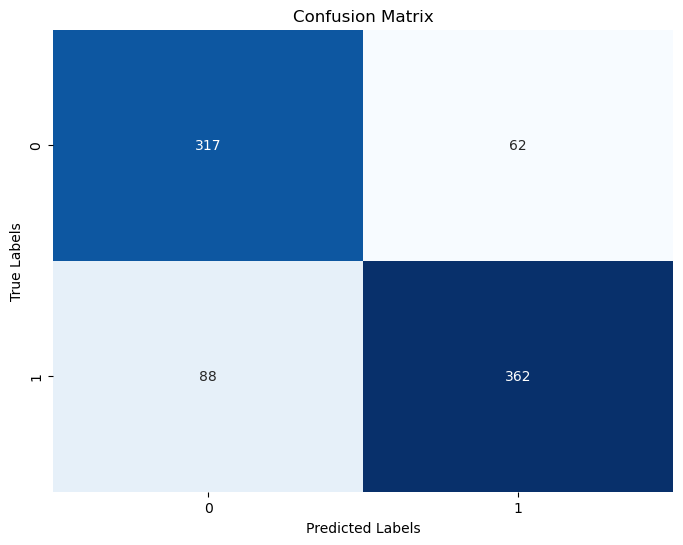

In [9]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()